# __Step 4.4: Topic over time__

Goals here:
- Analyze topics over time

Considerations:
- Time interval
  - The `topic_over_time` method doc in BERTopic has the following disclaimer: "Make sure to use a limited number of unique timestamps (<100) as the c-TF-IDF representation will be calculated at each single unique timestamp. Having a large number of unique timestamps can take some time to be calculated. Moreover, there aren't many use-cased where you would like to see the difference in topic representations over more than 100 different timestamps."
  - In light of this, the timestamps are generate at the year level.
    - Also realize that there are docs since 1917 but few of them in the early years. So pool docs before 1970 as one bin with a timestamp 1969.
    - There are very few 2021 articles (58) included due to publicaton time change. They are counted as 2020.
- Ok, after doing a `topic_over_time` run, I realize that the number of docs differ so much between the annual bins, it creates a whole host of issues. So do this instead:
  - Get a sorted timestamps list, without applying any thresholding.
  - Get every two percentile timestamp values and cut the whole dataset into 50 similar sized bins.
  - Note that the sizes are very similar but not the same because how I put things into bins.
- 8/25/22: Earlier `topic_over_time` manual run was with `global_tuning` on.
  - This is problematic because this lead to terms does not present in any docs in a time bin (so ctfidf=0) to have non-zero values and sometime even become top terms for that bin. 
  - An example is topic 61, term qtl. With global tuning, it is a top term for time bin 0, even though no doc talk about it.
  - Do another run and output ctfidf values with `_no_globaltune` extension.
  - And rerun all the rest of the analyses and graphing.

## ___Set up___

### Module import

In [51]:
import pickle, gzip
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
from pathlib import Path
from bertopic import BERTopic
from tqdm import tqdm
from datetime import datetime
from bisect import bisect
from sklearn.preprocessing import minmax_scale, normalize
from time import time
import plotly.graph_objects as go
from scipy.optimize import curve_fit

### Key variables

In [2]:
# Reproducibility
seed = 20220609

# Setting working directory
proj_dir   = Path.home() / "projects/plant_sci_hist"
work_dir   = proj_dir / "4_topic_model/4_4_over_time"
work_dir.mkdir(parents=True, exist_ok=True)

# plant science corpus
dir25       = proj_dir / "2_text_classify/2_5_predict_pubmed"
corpus_file = dir25 / "corpus_plant_421658.tsv.gz"

# processed docs
dir41            = proj_dir / "4_topic_model/4_1_compare_models"
docs_clean_file  = dir41 / "corpus_plant_421658_proc_txt.pkl"

# saved model, probability, and embedding files
dir42            = proj_dir / "4_topic_model/4_2_outlier_assign"
topic_model_file = dir42 / "topic_model_updated"
prob_file        = dir42 / "probs.pickle"
embedding_file   = dir42 / "embeddings_scibert.pickle"

# modified topic names
dir43            = proj_dir / "4_topic_model/4_3_model_analysis"
toc_mod_name_file= dir43 / 'fig4_3_topic_heatmap_seaborn_order_condensed.txt'

# So PDF is saved in a format properly
mpl.rcParams['pdf.fonttype'] = 42
plt.rcParams["font.family"] = "sans-serif"

# Creat a folder to store c-tf-idf matrix for each timestamp bin
ctfidf_dir = work_dir / "ctfidf_over_time"
ctfidf_dir.mkdir(parents=True, exist_ok=True)

# Create a folder to store topic over time graph for each topic
tot_graph_dir = work_dir / 'tot_graphs'
tot_graph_dir.mkdir(parents=True, exist_ok=True)

# Create a folder to store topic over time heatmaps
#tot_heatmap_dir = work_dir / 'tot_heatmaps'
#tot_heatmap_dir.mkdir(parents=True, exist_ok=True)

## ___Load data___

### Load original corpus

In [3]:
df_corpus = pd.read_csv(corpus_file, sep='\t')
df_corpus.head(3)

,Unnamed: 0,PMID,Date,Journal,Title,Abstract,QualifiedName,txt,reg_article,y_prob,y_pred
0,3,61,1975-12-11,Biochimica et biophysica acta,Identification of the 120 mus phase in the dec...,After a 500 mus laser flash a 120 mus phase in...,spinach,Identification of the 120 mus phase in the dec...,1,0.716394,1
1,4,67,1975-11-20,Biochimica et biophysica acta,Cholinesterases from plant tissues. VI. Prelim...,Enzymes capable of hydrolyzing esters of thioc...,plant,Cholinesterases from plant tissues. VI. Prelim...,1,0.894874,1
2,9,283,1975-01-01,Folia microbiologica,"Fructose 1,6-bisphosphate aldolase activity of...",FDP aldolase was found to be present in the ce...,sesbania,"Fructose 1,6-bisphosphate aldolase activity of...",1,0.901070,1


In [173]:
df_corpus.shape

(421658, 11)

### Load topic model and probability

In [4]:
# Load topic model
topic_model = BERTopic.load(topic_model_file)

In [5]:
# load prob
with open(prob_file, "rb") as f:
  probs = pickle.load(f)

### Load cleaned data

In [6]:
with open(docs_clean_file, "rb") as f:
  docs = pickle.load(f)

## ___Process datetime___

### Create a timestamps list for plotting article numbers

Note that the timestamp will be generated at the year level.
- pool docs before 1970 as one bin with a timestamp 1969.
- This is for plotting purpose.

In [8]:
# Get pandas series dates
dates = df_corpus['Date']
dates[0], dates[1]

('1975-12-11', '1975-11-20')

In [9]:
ts_for_plot = []
docs_yr     = [] # a list of years for generating bar graph later
early_doc   = {} # {year: count}
for date in dates:
  [yr, mo, da] = date.split('-') # year, month, day
  # docs from the same year has the same timestamp
  yr = int(yr)
  docs_yr.append(yr)

  # Create 
  if yr not in early_doc:
    early_doc[yr] = 1
  else:
    early_doc[yr]+= 1

  # Set year before 1970 as 1969.
  if yr < 1970:  
    yr = 1969

  # Set year after 2020 as 2020. There are 58 instances
  if yr > 2020:  
    yr = 2020

  dt   = datetime(yr, 1, 1)
  ts   = dt.timestamp()
  ts_for_plot.append(ts)
len(ts_for_plot)

421658

### Records per year bar graphs

In [179]:
# array with number of records per year
docs_year_array = np.unique(np.array(docs_yr), return_counts=True)

# dataframe with counts per year
docs_year_df    = pd.DataFrame(docs_year_array[1], columns=["Count"],
                               index=docs_year_array[0])

In [180]:
docs_year_df.loc[1965]

Count    97
Name: 1965, dtype: int64

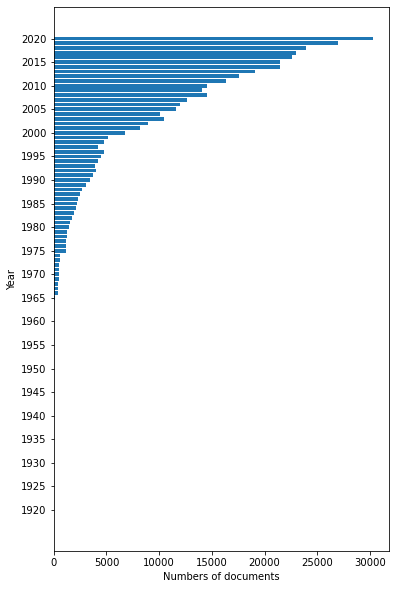

In [181]:
# without log
plt.figure(figsize=(6,10))
plt.barh(docs_year_array[0], docs_year_array[1])
plt.ylabel('Year')
plt.xlabel('Numbers of documents')
plt.yticks(range(1920, 2021, 5))
plt.savefig(work_dir / 'figure4_4_num_docs_per_year.pdf')

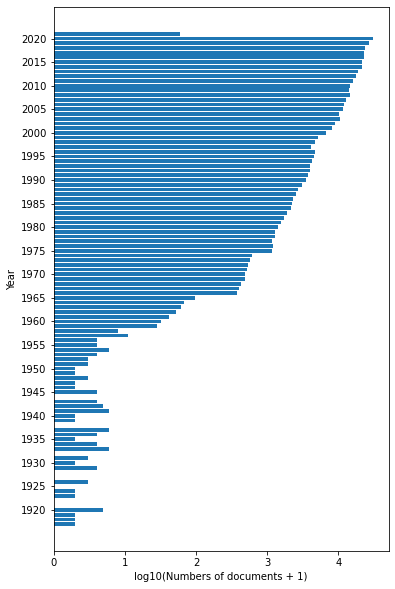

In [182]:
# logged
plt.figure(figsize=(6,10))
plt.barh(docs_year_array[0], np.log10(docs_year_array[1]+1))
plt.ylabel('Year')

# +1 so the x-axis value is not zero.
plt.xlabel('log10(Numbers of documents + 1)')
plt.yticks(range(1920, 2021, 5))
plt.savefig(work_dir / 'figure4_4_num_docs_per_year_logged.pdf')

### Spot check timestamp values

In [183]:
rand_ints = np.random.randint(df_corpus.shape[0], size=20)
for rand_int in rand_ints:
  date = df_corpus['Date'][rand_int]
  ts   = ts_for_plot[rand_int]
  print(date, "<-->", datetime.fromtimestamp(ts), ts)

2008-07-09 <--> 2008-01-01 00:00:00 1199163600.0
1983-10-01 <--> 1983-01-01 00:00:00 410245200.0
2003-11-06 <--> 2003-01-01 00:00:00 1041397200.0
1991-03-01 <--> 1991-01-01 00:00:00 662706000.0
2007-02-03 <--> 2007-01-01 00:00:00 1167627600.0
2006-04-07 <--> 2006-01-01 00:00:00 1136091600.0
2017-05-10 <--> 2017-01-01 00:00:00 1483246800.0
2020-01-02 <--> 2020-01-01 00:00:00 1577854800.0
2019-09-05 <--> 2019-01-01 00:00:00 1546318800.0
2017-08-26 <--> 2017-01-01 00:00:00 1483246800.0
2010-04-28 <--> 2010-01-01 00:00:00 1262322000.0
1994-01-01 <--> 1994-01-01 00:00:00 757400400.0
2003-03-20 <--> 2003-01-01 00:00:00 1041397200.0
2015-08-02 <--> 2015-01-01 00:00:00 1420088400.0
2013-02-05 <--> 2013-01-01 00:00:00 1357016400.0
2019-04-19 <--> 2019-01-01 00:00:00 1546318800.0
2016-01-07 <--> 2016-01-01 00:00:00 1451624400.0
1983-01-01 <--> 1983-01-01 00:00:00 410245200.0
2008-05-01 <--> 2008-01-01 00:00:00 1199163600.0
2016-04-20 <--> 2016-01-01 00:00:00 1451624400.0


In [184]:
min(ts_for_plot), max(ts_for_plot), datetime.fromtimestamp(min(ts_for_plot))

(-31518000.0, 1577854800.0, datetime.datetime(1969, 1, 1, 0, 0))

### Get the binned timestamp values

So the bins have similar numbers of docs.
- For this a new timestamp list is generated

In [10]:
# Turn all dates into timestamps 
ts_for_bins = []
for date in dates:
  [yr, mo, da] = date.split('-') # year, month, day
  dt   = datetime(int(yr), int(mo), int(da))
  ts   = dt.timestamp()
  ts_for_bins.append(ts)

In [11]:
ts_for_bins.sort()

In [12]:
# bin size
bin_size       = int(len(ts_for_bins)/50)

# index values of every 2 percentile (because the data is broken into 50 parts)
bin_idxs       = [idx for idx in range(0, len(ts_for_bins), bin_size)]

# timestamp values at bin_idxs
bin_timestamps = [ts_for_bins[idx] for idx in bin_idxs]

# Modify the last value to be the max timestamp value + 1. This is otherwise
# because of the bin_size is rounded down the last value be smaller than the max
# timestamp values. Also, +1 to the max value, otherwise, the last entries will
# be in its own bin.
max_timestamp      = max(ts_for_bins) + 1
bin_timestamps[-1] = max_timestamp

# dates correspond to the different timestamp
bin_dates      = [datetime.fromtimestamp(ts) for ts in bin_timestamps]

# Put idx, timestamp, and date into a dataframe and save it.
bin_df         = pd.DataFrame(list(zip(bin_idxs, bin_timestamps, bin_dates)),
            columns=['bin_start_idx', 'bin_start_timestamp', 'bin_start_date'])
bin_df.to_csv(work_dir / "table4_4_bin_timestamp_date.tsv", sep='\t')

In [13]:
bin_df.head(), bin_df.tail()

(   bin_start_idx  bin_start_timestamp bin_start_date
 0              0        -1.646248e+09     1917-11-01
 1           8433         2.507508e+08     1977-12-12
 2          16866         4.258800e+08     1983-07-01
 3          25299         5.468400e+08     1987-05-01
 4          33732         6.389460e+08     1990-04-01,
     bin_start_idx  bin_start_timestamp      bin_start_date
 46         387918         1.574053e+09 2019-11-18 00:00:00
 47         396351         1.583557e+09 2020-03-07 00:00:00
 48         404784         1.592712e+09 2020-06-21 00:00:00
 49         413217         1.601438e+09 2020-09-30 00:00:00
 50         421650         1.609477e+09 2021-01-01 00:00:01)

### Generate the binned timestamps

In [14]:
# Assign new timestamps based on the bin timestamp values
ts_in_bins = []
for date in dates:
  [yr, mo, da] = date.split('-') # year, month, day
  dt   = datetime(int(yr), int(mo), int(da))
  ts   = dt.timestamp()

  bin_idx = bisect(bin_timestamps, ts)

  if bin_idx < len(bin_timestamps):
    ts2     = bin_timestamps[bin_idx]
  # Deal with the last bin
  else:
    ts2     = datetime(2022, 12, 31).timestamp()
  ts_in_bins.append(ts2) 

In [16]:
len(ts_in_bins)

421658

## ___Topic over time___

### Setup `topics_over_time`

Bertopic [doc](https://maartengr.github.io/BERTopic/api/bertopic.html#bertopic._bertopic.BERTopic.topics_over_time)
- docs,	List[str]: docs used when calling either fit or fit_transform
  - Set to `df_corpus[txt]`
- topics, List[int]: topics that were returned when calling either fit or fit_transform
  - See `script_4_3` using np.argmax to get topics
- timestamps,	Union[List[str], List[int]]: The timestamp of each document. This can be either a list of strings or ints.
  - Set to `timestamps` 
- nr_bins, int: The number of bins you want to create for the timestamps.
  - From 1969 to 2000, so `52` bins
- datetime_format, str: The datetime format of the timestamps if they are strings, eg “%d/%m/%Y”. Set this to None if you want to have it automatically detect the format. 
  - Set to `None`
- evolution_tuning,	bool: Fine-tune each topic representation at timestamp t by averaging its c-TF-IDF matrix with the c-TF-IDF matrix at timestamp t-1. This creates evolutionary topic representations.
  - Set to `True`
- global_tuning, bool: Fine-tune each topic representation at timestamp t by averaging its c-TF-IDF matrix with the global c-TF-IDF matrix. Turn this off if you want to prevent words in topic representations that could not be found in the documents at timestamp t.
  - Set to `True`

In [17]:
probability_threshold = np.percentile(probs, 95)
topics = [np.argmax(prob) if max(prob) >= probability_threshold else -1 
                                                            for prob in probs]

In [18]:
np.unique(np.array(ts_in_bins), return_counts=True)

(array([2.5075080e+08, 4.2588000e+08, 5.4684000e+08, 6.3894600e+08,
        7.1264160e+08, 7.7839200e+08, 8.3619360e+08, 8.9753760e+08,
        9.4972680e+08, 9.8696160e+08, 1.0184112e+09, 1.0464948e+09,
        1.0722420e+09, 1.0992852e+09, 1.1230416e+09, 1.1461968e+09,
        1.1676276e+09, 1.1886192e+09, 1.2090096e+09, 1.2259476e+09,
        1.2457296e+09, 1.2641364e+09, 1.2826224e+09, 1.3001616e+09,
        1.3161456e+09, 1.3323024e+09, 1.3473360e+09, 1.3622004e+09,
        1.3759344e+09, 1.3897620e+09, 1.4022000e+09, 1.4149008e+09,
        1.4273424e+09, 1.4396976e+09, 1.4519700e+09, 1.4637168e+09,
        1.4758992e+09, 1.4873940e+09, 1.4989680e+09, 1.5103764e+09,
        1.5218640e+09, 1.5327504e+09, 1.5439860e+09, 1.5541776e+09,
        1.5640272e+09, 1.5740532e+09, 1.5835572e+09, 1.5927120e+09,
        1.6014384e+09, 1.6094772e+09]),
 array([8433, 8313, 8483, 8352, 8510, 8391, 8432, 8550, 8425, 8424, 8436,
        8372, 8497, 8398, 8463, 8448, 8420, 8379, 8488, 8420, 8393, 84

In [19]:
docs             = docs
topics           = topics
timestamps       = ts_in_bins
nr_bins          = 50
evolution_tuning = True
global_tuning    = True

## ___Manual run `topic_over_time`___

The above take a long time and the output is not exactly what I am looking for.
- The words column: would be nice to have c-Tf-Idf values for whatever words that I am interested in. But this only report top 5.

### Get global c-Tf-Idf

In [23]:
# Get the global (i.e., based on the whole timef rame) ctfidf values
global_c_tf_idf = normalize(topic_model.c_tf_idf, axis=1, norm='l1', copy=False)
global_c_tf_idf.shape

(91, 18850331)

### Set up documents dataframe with timestamp bins

In [24]:
# Construct a documents dataframe
documents = pd.DataFrame({"Document": docs, "Topic": topics, 
                          "Timestamps": timestamps})

In [25]:
# Get topic names, ordered and then get their indices, 0-based
all_topics = sorted(list(documents.Topic.unique()))
all_topics_indices = {topic: index for index, topic in enumerate(all_topics)}
len(all_topics), all_topics[0], type(all_topics_indices), all_topics_indices[-1]

(91, -1, dict, 0)

In [26]:
# Bin values into discrete intervals
# The original code does not work for me because my timestamp bins are not sized
# equally. With the following code, 32 bins are created instead of 50.
#documents["Bins"]       = pd.cut(documents.Timestamps, bins=nr_bins)

# Testing
bins = pd.cut(documents.Timestamps, bins=nr_bins)
type(bins[0]), bins[0]

(pandas._libs.interval.Interval,
 Interval(249392073.599, 277925328.02, closed='right'))

In [27]:
ts_bins   = [] # a list of tuples showing the bin range (+/-1 of the unique val)
for ts in timestamps:
  ts_bins.append(pd.Interval(left=ts-1, right=ts+1))

In [28]:
documents["Bins"] = ts_bins

In [29]:
documents["Timestamps"] = documents.apply(lambda row: row.Bins.left, 1)
documents.head(2)

,Document,Topic,Timestamps,Bins
0,identification 120 mus phase decay delayed flu...,52,250750799.0,"(250750799.0, 250750801.0]"
1,cholinesterases plant tissues . vi . prelimina...,48,250750799.0,"(250750799.0, 250750801.0]"


In [30]:
# When passed already sorted, but just in case
# Sort documents in chronological order
documents  = documents.sort_values("Timestamps")

# Unique timestamps
ts_unique = documents.Timestamps.unique()
len(ts_unique), ts_unique

(50,
 array([2.50750799e+08, 4.25879999e+08, 5.46839999e+08, 6.38945999e+08,
        7.12641599e+08, 7.78391999e+08, 8.36193599e+08, 8.97537599e+08,
        9.49726799e+08, 9.86961599e+08, 1.01841120e+09, 1.04649480e+09,
        1.07224200e+09, 1.09928520e+09, 1.12304160e+09, 1.14619680e+09,
        1.16762760e+09, 1.18861920e+09, 1.20900960e+09, 1.22594760e+09,
        1.24572960e+09, 1.26413640e+09, 1.28262240e+09, 1.30016160e+09,
        1.31614560e+09, 1.33230240e+09, 1.34733600e+09, 1.36220040e+09,
        1.37593440e+09, 1.38976200e+09, 1.40220000e+09, 1.41490080e+09,
        1.42734240e+09, 1.43969760e+09, 1.45197000e+09, 1.46371680e+09,
        1.47589920e+09, 1.48739400e+09, 1.49896800e+09, 1.51037640e+09,
        1.52186400e+09, 1.53275040e+09, 1.54398600e+09, 1.55417760e+09,
        1.56402720e+09, 1.57405320e+09, 1.58355720e+09, 1.59271200e+09,
        1.60143840e+09, 1.60947720e+09]))

### Run all timestamps

This takes ~1.5 to 2 hours, depending on the load of my machine.

In [57]:
# For each unique timestamp, create topic representations
topics_over_time = []
for index, timestamp in enumerate(tqdm(ts_unique)):
  # Calculate c-TF-IDF representation for a specific timestamp
  selection = documents.loc[documents.Timestamps == timestamp, :]
  docs_per_toc = selection.groupby(['Topic'], as_index=False).agg(
                                {'Document': ' '.join, "Timestamps": "count"})
  c_tf_idf, words = topic_model._c_tf_idf(docs_per_toc, fit=False)

  if global_tuning or evolution_tuning:
    c_tf_idf = normalize(c_tf_idf, axis=1, norm='l1', copy=False)

  # Fine-tune the c-TF-IDF matrix at timestamp t by averaging it with the 
  # c-TF-IDF matrix at timestamp t-1
  if evolution_tuning and index != 0:
    curr_toc         = sorted(list(docs_per_toc.Topic.values))
    overlap_toc      = sorted(list(set(prev_toc).intersection(set(curr_toc))))
    curr_overlap_idx = [curr_toc.index(topic) for topic in overlap_toc]
    prev_overlap_idx = [prev_toc.index(topic) for topic in overlap_toc]

    c_tf_idf.tolil()[curr_overlap_idx] = \
      ((c_tf_idf[curr_overlap_idx] + prev_c_tf_idf[prev_overlap_idx]) / 2.0).tolil()

  # Fine-tune the timestamp c-TF-IDF representation based on the global c-TF-IDF representation
  # by simply taking the average of the two
  #if global_tuning:
  #  selected_topics = [all_topics_indices[topic] \
  #                                      for topic in docs_per_toc.Topic.values]
  #  c_tf_idf = (global_c_tf_idf[selected_topics] + c_tf_idf) / 2.0

  # Extract the words per topic
  labels = sorted(list(docs_per_toc.Topic.unique()))
  words_per_toc = topic_model._extract_words_per_topic(words, c_tf_idf, labels)
  topic_frequency = pd.Series(docs_per_toc.Timestamps.values,
                                index=docs_per_toc.Topic).to_dict()
  # Fill dataframe with results
  topics_at_timestamp = [(topic,
                          ", ".join([words[0] for words in values][:5]),
                          topic_frequency[topic],
                          timestamp) for topic, values in words_per_toc.items()]
  topics_over_time.extend(topics_at_timestamp)

  if evolution_tuning:
    prev_toc = sorted(list(docs_per_toc.Topic.values))
    prev_c_tf_idf = c_tf_idf.copy()

  # Save the word list if this is the 1st timestamp
  if index == 0:
    word_file = ctfidf_dir / f"word_list_{len(words)}.pickle"
    with open(word_file, 'wb') as f:
      pickle.dump(words, f)

  # Save the ctfidf values
  ctfidf_file = ctfidf_dir / f'ctfidf_{index}_no_globatune.pickle'
  with open(ctfidf_file, "wb") as f:
    pickle.dump(c_tf_idf, f)

  # Save index and topic name for cross-referencing in ctfidf_file
  toc_index_file = ctfidf_dir / f"ctfidf_{index}_toc_index.tsv"
  docs_per_toc['Topic'].to_csv(toc_index_file, sep='\t')


100%|██████████| 50/50 [2:08:24<00:00, 154.10s/it]  


In [59]:
topics_over_time = pd.DataFrame(topics_over_time, 
                          columns=["Topic", "Words", "Frequency", "Timestamp"])

In [60]:
tot_df_file = work_dir / "table4_4_topics_over_time_df_no_global_tune.tsv"
topics_over_time.to_csv(tot_df_file, sep='\t')
topics_over_time

,Topic,Words,Frequency,Timestamp
0,-1,"cells, growth, acid, activity, tissue",981,2.507508e+08
1,0,"timothy, timothy pollen, antigen, ragweed, all...",8,2.507508e+08
2,1,"callus, medium, kinetin, culture, protoplasts",85,2.507508e+08
3,2,"berberinium, viscometric titrations, flow pola...",2,2.507508e+08
4,3,"amiben, atrazine, gsatrazine, atrazine metabol...",4,2.507508e+08
...,...,...,...,...
4457,85,"soil, yield, nitrogen, ha1, stress",221,1.609477e+09
4458,86,"dispersal, genetic, populations, evolution, sp...",66,1.609477e+09
4459,87,"flowers, floral, pollinator, bees, pollination",72,1.609477e+09
4460,88,"genetic, populations, diversity, genetic diver...",71,1.609477e+09


## ___Topic over time plots___

### Default function

In [40]:
topic_model.visualize_topics_over_time(topics_over_time,
                                       topics=[0],
                                       normalize_frequency=True)

### Plot with modified function

Customize `BERTopic/bertopic/plotting/_topics_over_time.py`:
- Plot one topic at a time
- Replace x-axis with dates converted from time stamps
- Save the plot in html and pdf formats

In [65]:
def visualize_tot_mod(topic_model, topics_over_time, topics=None, 
                      normalize_frequency=False, width=1000, height=400):

  colors = ["#56B4E9", "#E69F00", "#009E73", "#F0E442", "#D55E00", "#0072B2", 
            "#CC79A7"]

  # Select topics
  if topics:
    selected_topics = topics
  else:
    selected_topics = topic_model.get_topic_freq().Topic.values

  # Prepare data
  topic_names = {key: value[:40] + "..." if len(value) > 40 else value
                       for key, value in topic_model.topic_names.items()}
  topics_over_time["Name"] = topics_over_time.Topic.map(topic_names)
  data = topics_over_time.loc[
    topics_over_time.Topic.isin(selected_topics), :].sort_values(
        ["Topic", "Timestamp"])
    
  # Add traces
  fig = go.Figure()
  max_freq = 0  # set max frequency for plotting purpose
  for index, topic in enumerate(data.Topic.unique()):
    trace_data = data.loc[data.Topic == topic, :]
    topic_name = trace_data.Name.values[0]
    words = trace_data.Words.values
    if normalize_frequency:
      y = normalize(trace_data.Frequency.values.reshape(1, -1))[0]
    else:
      y = trace_data.Frequency

    if max(y) > max_freq:
      max_freq = max(y)
    fig.add_trace(go.Scatter(x=trace_data.Timestamp, y=y, mode='lines+markers',
      marker_color=colors[index % 7], hoverinfo="text",
      name=topic_name,
      hovertext=[f'<b>Topic {topic}</b><br>Words: {word}' for word in words]))

  # Set the xaxis values, just use topic=0 
  unique_tss = data.loc[data.Topic == selected_topics[0], :].Timestamp.tolist()
  datetimes  = [datetime.fromtimestamp(ts) for ts in unique_tss]
  ymds       = [f'{dt.year}-{dt.month}-{dt.day}' for dt in datetimes]
  
  # At recent date it becomes too dense, so only show every 2 dates
  skip_after = datetime(2011, 1, 1).timestamp()
  skip_start_idx = bisect(unique_tss, skip_after)
  unique_tss2 = unique_tss[:skip_start_idx] + unique_tss[skip_start_idx::2]
  ymds2       = ymds[:skip_start_idx] + ymds[skip_start_idx::2]

  # Styling of the visualization
  toc_str    = "-".join([str(toc) for toc in topics])

  fig.update_xaxes(showgrid=True)
  fig.update_yaxes(showgrid=True)
  fig.update_layout(
    yaxis_title="Normalized Frequency" if normalize_frequency else "Frequency",
    title={'text': f"<b>Topic(s): {toc_str}",
           'y': .95,
           'x': 0.40,
           'xanchor': 'center',
           'yanchor': 'top',
           'font': dict(size=22, color="Black")},
    template="simple_white",
    width=width,
    height=height,
    hoverlabel=dict(bgcolor="white", font_size=16, font_family="Rockwell"),
    legend=dict(title="<b>Global Topic Representation"),
    xaxis=dict(tickmode='array', tickvals=unique_tss2, ticktext=ymds2,
               tickangle=-60))

  # Add decade lines
  for decade in range(1980, 2020, 10):
    dt = datetime(decade, 1, 1)
    ts = datetime.timestamp(dt)
    fig.add_shape(type="line", x0=ts, y0=0, x1=ts, y1=max_freq*1.05,
                  line=dict(color="red", width=3, dash='dot'))

  # Save figure
  fig.write_html(tot_graph_dir / f'tot_graph_topic_{toc_str}_no_globaltune.html')
  fig.write_image(tot_graph_dir / f'tot_graph_topic_{toc_str}_no_globaltune.pdf')

  return fig, unique_tss

In [69]:
# Testing with topic 2
fig, unique_tss = visualize_tot_mod(topic_model, topics_over_time, topics=[2])
print(unique_tss)

[250750799.0, 425879999.0, 546839999.0, 638945999.0, 778391999.0, 836193599.0, 897537599.0, 949726799.0, 986961599.0, 1018411199.0, 1046494799.0, 1072241999.0, 1099285199.0, 1123041599.0, 1146196799.0, 1167627599.0, 1188619199.0, 1209009599.0, 1225947599.0, 1245729599.0, 1264136399.0, 1282622399.0, 1300161599.0, 1316145599.0, 1332302399.0, 1347335999.0, 1362200399.0, 1375934399.0, 1389761999.0, 1402199999.0, 1414900799.0, 1427342399.0, 1439697599.0, 1451969999.0, 1463716799.0, 1475899199.0, 1487393999.0, 1498967999.0, 1510376399.0, 1521863999.0, 1532750399.0, 1543985999.0, 1554177599.0, 1564027199.0, 1574053199.0, 1583557199.0, 1592711999.0, 1601438399.0, 1609477200.0]


In [70]:
fig

In [63]:
# Go through all topics
for topic in tqdm(range(0,90)):
  visualize_tot_mod(topic_model, topics_over_time, topics=[topic])

100%|██████████| 90/90 [00:18<00:00,  4.81it/s]


## ___Topic representation heatmap___

### Process topic frequency over time

- Get the unique topics from topics_over_time.Topic.unique()
  - I assumed that it would be sorted. Turned out that it is NOT. Fixed.
- Create a nested list where each element is a list of frequencies for a topic
  - The outlier cluster is excluded.
- Problem with outlier frequency
  -  If I use clustermap's standard_scale parameter, the heatmap for some topics, (57, 75, 76, 54, 73) are not useful because there is a large outlier driven all other values to be small so use sklearn's function instead.
  - The problem is though, the most useful methods against outliers transform the data so the shape of distribution changes. The heatmap is not particularly useful.
  - Compromise, for the 5 topics listed above, the max value is set to be 120% of the 2nd highest values.
- Problem with NA
  - Some time points there are no data: replace NA with 0.

In [71]:
# Sort unique topics
tocs = topics_over_time.Topic.unique()
tocs.sort()
tocs

array([-1,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15,
       16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32,
       33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49,
       50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66,
       67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83,
       84, 85, 86, 87, 88, 89])

In [72]:
# Create a nested list where each element is a list of frequencies for a topic
# The outlier cluster is excluded.
tot_freq = []
toc_outlier_modify = [57, 75, 76, 54, 73]
for topic in tocs[1:]:

  # topics_over_time sub-dataframe for a topic
  toc_data = topics_over_time.loc[topics_over_time.Topic == topic, :]
  # timestamps
  tss      = toc_data.Timestamp.values.tolist()
  # frequency for each timestamp
  freq = toc_data.Frequency.values.tolist()
  # Deal with max values in the five topics specified
  if topic in toc_outlier_modify:
    # index of max value
    idx_max    = freq.index(max(freq))
    # create a new list and remove the max value
    freq_copy = freq.copy()
    freq_copy.remove(max(freq))
    # index of the second max value
    idx_2ndmax = freq_copy.index(max(freq_copy))
    # set max value to 120% of the 2nd max value
    freq[idx_max] = freq[idx_2ndmax]*1.2

  # turn freq into a 2D array of shape (1, len(freq)), 
  freq = np.reshape(freq, (1, len(freq)))
  # min-max scale freq and get the 1d array back
  freq = minmax_scale(freq, axis=1)[0]

  # Check if all 50 timestamp bins are present, if not, fill in zero.
  freq_50  = []
  for ts in ts_unique:
    if ts in tss:
      idx = tss.index(ts)
      freq_50.append(freq[idx])
    else:
      freq_50.append(0)

  tot_freq.append(freq_50)
#len(tot_freq), len(tot_freq[0])

In [73]:
# Make a dataframe
tot_freq_df = pd.DataFrame(tot_freq, 
                           columns=ts_unique)

# check if there is missing data still.
tot_freq_df.isnull().sum().sum()

0

### Plot heatmap

In [79]:
np.asarray(unique_tss), ts_unique

(array([2.50750799e+08, 4.25879999e+08, 5.46839999e+08, 6.38945999e+08,
        7.78391999e+08, 8.36193599e+08, 8.97537599e+08, 9.49726799e+08,
        9.86961599e+08, 1.01841120e+09, 1.04649480e+09, 1.07224200e+09,
        1.09928520e+09, 1.12304160e+09, 1.14619680e+09, 1.16762760e+09,
        1.18861920e+09, 1.20900960e+09, 1.22594760e+09, 1.24572960e+09,
        1.26413640e+09, 1.28262240e+09, 1.30016160e+09, 1.31614560e+09,
        1.33230240e+09, 1.34733600e+09, 1.36220040e+09, 1.37593440e+09,
        1.38976200e+09, 1.40220000e+09, 1.41490080e+09, 1.42734240e+09,
        1.43969760e+09, 1.45197000e+09, 1.46371680e+09, 1.47589920e+09,
        1.48739400e+09, 1.49896800e+09, 1.51037640e+09, 1.52186400e+09,
        1.53275040e+09, 1.54398600e+09, 1.55417760e+09, 1.56402720e+09,
        1.57405320e+09, 1.58355720e+09, 1.59271200e+09, 1.60143840e+09,
        1.60947720e+09]),
 array([2.50750799e+08, 4.25879999e+08, 5.46839999e+08, 6.38945999e+08,
        7.12641599e+08, 7.78391999e+08

In [80]:
# Get the dates of unique timestamps to label y-axis
ts_unique_dts = [datetime.fromtimestamp(ts) for ts in ts_unique]
ts_unique_dts = [f"{dt.year}-{dt.month}-{dt.day}" for dt in ts_unique_dts]

In [81]:
# xtick location:
#https://stackoverflow.com/questions/49420563/how-can-i-move-the-xlabel-to-the-top
# does not work

# Resize
#https://www.delftstack.com/howto/seaborn/size-of-seaborn-heatmap/
# The 1st two solutions do not work 

# Customize color bar
#https://stackoverflow.com/questions/67909597/seaborn-clustermap-colorbar-adjustment

def plot_clustermap(df, xticklabels, cmap):

  # color bar parameters: cannot get the dimension right
  #kws = dict(cbar_kws=dict(ticks=[0, 0.25, 0.5, 0.75, 1], 
  #           orientation='horizontal'), figsize=(6, 6))
  methods = ["single", "complete", "average", "weighted", "centroid", "median", 
           "ward"]
  
  for method in methods:
    # Originally have:
    # standard_scale=0: not used, normalize before hand. 
    # **kws: was used to manipulate colormap, but didn't seem to work.
    cgrid = sns.clustermap(df, cmap=cmap, 
                          row_cluster=True, col_cluster=False,
                          method=method,
                          xticklabels=xticklabels,
                          yticklabels=True)
    # Set size  
    plt.gcf().set_size_inches(10, 18)

    # Create heatmap plot folder for the specific method
    tot_heatmap_dir = work_dir / f"tot_heatmaps_{cmap}"
    tot_heatmap_dir.mkdir(parents=True, exist_ok=True)

    # Save the heatmap
    cgrid.savefig(tot_heatmap_dir / f'fig4_4_tot_heatmap_{method}_no_globaltune.pdf')
    # Save the row order
    order_idx = cgrid.dendrogram_row.reordered_ind
    order_idx = [str(idx) for idx in order_idx]

    with open(tot_heatmap_dir / f'fig4_4_tot_heatmap_{method}_index_no_globaltune.txt', "w") as f:
      f.write(",".join(order_idx))

    plt.close() # prevent image from showing

In [82]:
plot_clustermap(tot_freq_df, ts_unique_dts, "RdPu")

In [83]:
plot_clustermap(tot_freq_df, ts_unique_dts, "coolwarm")
plot_clustermap(tot_freq_df, ts_unique_dts, "icefire")
plot_clustermap(tot_freq_df, ts_unique_dts, "viridis")

## ___Heatmap with scaled cell size___

Based on the weighted heatmap

### Setup x ticks and labels: 1st try

First try: setting the bound using mid-point values:
- This create plots that are of different range from the line plots generated above.
- No good.


In [92]:
# Testing bound
# ts0, ts1
ts0 = ts_unique[0]
ts1 = ts_unique[1]
# points, length, mid-point
ts0, ts1, ts1-ts0, (ts1-ts0)/2 + ts0, type(ts_unique), len(ts_unique)

(250750799.0, 425879999.0, 175129200.0, 338315399.0, numpy.ndarray, 50)

In [90]:
# Midpoints for the x-axis
midpointsX = (ts_unique[:-1] + ts_unique[1:]) / 2
midpointsX.shape, midpointsX[:2]

((49,), array([3.38315399e+08, 4.86359999e+08]))

In [91]:

# Bounds for the x axis defined based on mid-points
boundsX = np.concatenate([[2*midpointsX[0]-midpointsX[1]], 
                         midpointsX, 
                         [2*midpointsX[-1]-midpointsX[-2]]])
boundsX.shape, boundsX

((51,),
 array([1.90270799e+08, 3.38315399e+08, 4.86359999e+08, 5.92892999e+08,
        6.75793799e+08, 7.45516799e+08, 8.07292799e+08, 8.66865599e+08,
        9.23632199e+08, 9.68344199e+08, 1.00268640e+09, 1.03245300e+09,
        1.05936840e+09, 1.08576360e+09, 1.11116340e+09, 1.13461920e+09,
        1.15691220e+09, 1.17812340e+09, 1.19881440e+09, 1.21747860e+09,
        1.23583860e+09, 1.25493300e+09, 1.27337940e+09, 1.29139200e+09,
        1.30815360e+09, 1.32422400e+09, 1.33981920e+09, 1.35476820e+09,
        1.36906740e+09, 1.38284820e+09, 1.39598100e+09, 1.40855040e+09,
        1.42112160e+09, 1.43352000e+09, 1.44583380e+09, 1.45784340e+09,
        1.46980800e+09, 1.48164660e+09, 1.49318100e+09, 1.50467220e+09,
        1.51612020e+09, 1.52730720e+09, 1.53836820e+09, 1.54908180e+09,
        1.55910240e+09, 1.56904020e+09, 1.57880520e+09, 1.58813460e+09,
        1.59707520e+09, 1.60545780e+09, 1.61384040e+09]))

### Setup x ticks and labels: 2nd try

Use the `ts_unique` list. Considerations:
- `ts_unique` has 50 values start with the end point of the 1st bin (1971-11-1).
- Need 51 values to specify 50 bins.
- So need add a value to represent the beginning time (use 1971-1-1 to make the cell not so big).

In [102]:
len(ts_unique)

50

In [108]:
ts_begin = datetime(1971, 1, 1).timestamp()
boundsX  = np.insert(ts_unique, 0, ts_begin)
len(boundsX)

51

### Setup y ticks and labels

In [94]:
# For y-axis
toc_nooutlier = np.arange(90)
midpointsY = (toc_nooutlier[:-1] + toc_nooutlier[1:]) / 2
boundsY    = np.concatenate([[2*midpointsY[0]-midpointsY[1]], 
                            midpointsY, 
                            [2*midpointsY[-1]-midpointsY[-2]]])

In [95]:
# xtick labels
xticklabels = ["1917-1-1"] + ts_unique_dts

In [96]:
# topic names ordered in the weighted heatmap
tot_heatmap_RdPu_dir = work_dir / "tot_heatmaps_RdPu"
idx_file = tot_heatmap_RdPu_dir / \
                      f'fig4_4_tot_heatmap_weighted_index_no_globaltune.txt'
with open(idx_file, "r") as f:
  idxs = [int(idx) for idx in f.readline().split(",")]

# Set yticklabel names
yticklabels = [str(i) for i in idxs]

print(idxs)

[61, 32, 54, 80, 87, 46, 26, 27, 34, 25, 11, 41, 33, 24, 72, 30, 16, 60, 73, 74, 59, 67, 15, 86, 89, 29, 88, 78, 10, 69, 21, 75, 17, 65, 8, 6, 13, 64, 9, 83, 28, 31, 42, 36, 70, 19, 84, 55, 79, 85, 53, 43, 2, 14, 23, 82, 57, 40, 71, 3, 68, 77, 58, 4, 81, 56, 51, 38, 39, 20, 62, 12, 49, 50, 76, 0, 35, 37, 63, 1, 47, 48, 66, 5, 7, 44, 45, 52, 18, 22]


In [97]:
# Reorder y-axis
tot_freq_df_reordered = tot_freq_df.reindex(idxs)

In [99]:
tot_freq_df_reordered.shape

(90, 50)

### Generate scaled heatmap

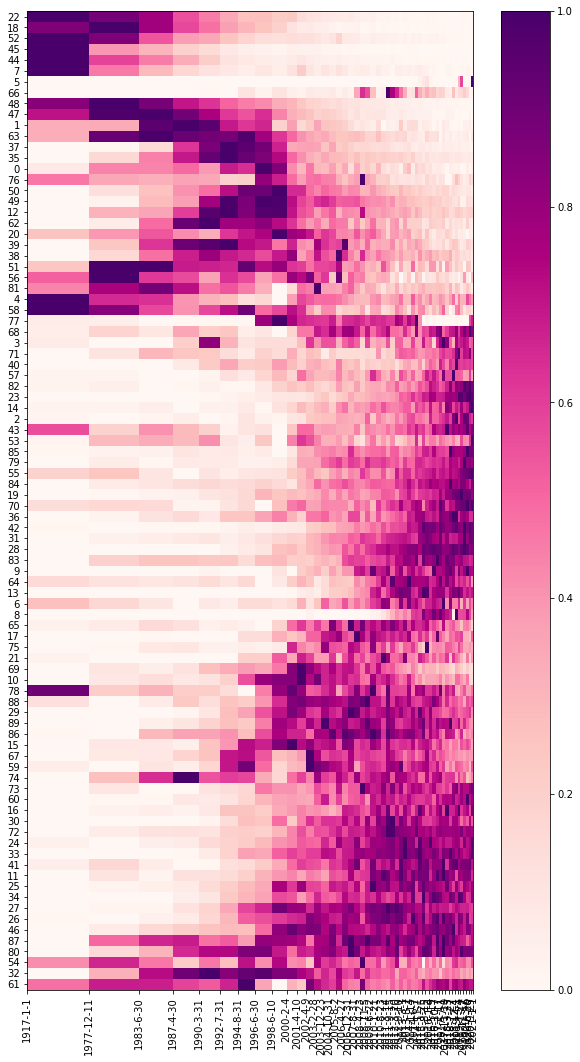

In [109]:
# Plotting
fig, ax = plt.subplots(figsize=(10,18))
plot = ax.pcolormesh(boundsX, boundsY, tot_freq_df_reordered, cmap="RdPu")
ax.set_xticks(boundsX)
ax.set_xticklabels(xticklabels, rotation=90)
ax.set_yticks(np.arange(len(idxs)))
ax.set_yticklabels(yticklabels)
ax.grid(False)
fig.colorbar(plot)
plt.savefig(work_dir / 'fig4_4_tot_heatmap_weighted_xscaled_no_globaltune.pdf')
plt.show()


### Get modified names orderd based on the scaled heatmap

In [110]:
# Set yticklabels based on modified names
toc_mod_names = pd.read_csv(toc_mod_name_file, names=["Topic", "Mod_name"], 
                            sep='\t')

In [111]:
# Sort toc_mod_names based on the topic name indices
#https://stackoverflow.com/questions/26202926/sorting-a-pandas-dataframe-by-the-order-of-a-list
toc_mod_names = toc_mod_names.set_index('Topic')
toc_mod_names.head(3)

,Mod_name
Topic,
-1,cell | expression | gene | protein
13,mirna | rnas | micrornas | target | lncrnas
21,circadian clock | rhythms | flowering | arabid...


In [112]:
# Drop outlier topic: don't really need to do this since in the next step, the
# outlier topic index is not there. But just for the sake of being safe...
#https://www.freecodecamp.org/news/drop-list-of-rows-from-pandas-dataframe/
toc_mod_names.drop([-1], axis=0, inplace=True)
toc_mod_names.head(2)

,Mod_name
Topic,
13,mirna | rnas | micrornas | target | lncrnas
21,circadian clock | rhythms | flowering | arabid...


In [114]:
idxs_rev = idxs.copy()
idxs_rev.reverse()
toc_mod_names_ordered = toc_mod_names.loc[idxs_rev]
toc_mod_names_ordered.head(2), toc_mod_names_ordered.tail(2)

(                                       Mod_name
 Topic                                          
 22     enzyme | fatty acids | lipid | synthesis
 18       protein | dna | rna | synthesis | mrna,
                                             Mod_name
 Topic                                               
 32     nodules | genes | strain | mutant | virulence
 61       qtl | resistance | wheat | markers | traits)

In [115]:
toc_mod_names_ordered.to_csv( work_dir / \
      'fig4_4_tot_heatmap_weighted_xscaled_names_no_globaltune.txt', sep='\t')

## ___Detect transition___

This is to ask the question whether there is distinct transition points for the topics. Did not work well.

### Define sigmoid function and test

- Do this by fitting a sigmoidal function to the relative freq values of each topic.
- This does not work well
- See [this post](https://stackoverflow.com/questions/48506782/scipy-curve-fit-how-to-plot-the-fitted-curve-beyond-the-data-points) for the function.


In [573]:
def sigmoid(x, L ,x0, k, b):
    y = L / (1 + np.exp(-k*(x-x0))) + b
    return (y)

/tmp/ipykernel_6789/2071294383.py:2: RuntimeWarning:

overflow encountered in exp

/tmp/ipykernel_6789/2071294383.py:2: RuntimeWarning:

overflow encountered in exp



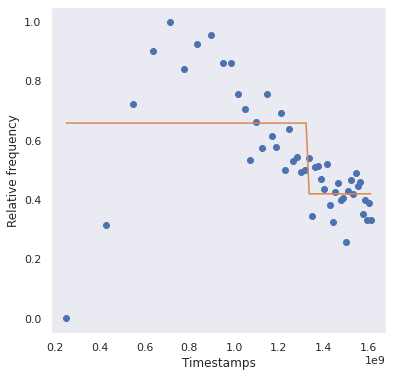

In [582]:
# Testing
xdata = ts_unique
ydata = tot_freq_df_reordered.iloc[1]

p0 = [max(ydata), np.median(xdata),1,min(ydata)]
popt, pcov = curve_fit(sigmoid, xdata, ydata,p0, method='dogbox')

x_fit = np.linspace(xdata[0], xdata[-1], 100)

plt.figure(figsize=(6,6))
plt.plot(xdata, ydata, 'o', label='data')
plt.plot(x_fit, sigmoid(x_fit, *popt), '-', label='Fit')
plt.xlabel("Timestamps")
plt.ylabel("Relative frequency")
plt.show()

### Define absolute intertopic distance

Idea is that there should be positive abs. distances before transition, near zero at transition point, and positive abs. distances again after transition. 
- This does not work either.


100%|██████████| 90/90 [00:00<00:00, 7409.70it/s]


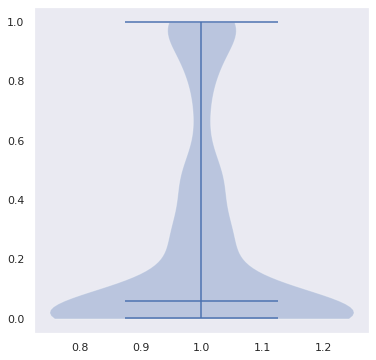

In [592]:
# Testing
ts_idx = 0
freqs  = tot_freq_df.iloc[:, ts_idx]
dist_L = []
for i in tqdm(range(len(ts0))):
  for j in range(i+i, len(ts0)):
    dist_L.append(abs(ts0[i]-ts0[j]))

plt.figure(figsize=(6,6))
plt.violinplot(dist_L, showmedians=True)
plt.show()

In [596]:
all_dist_L = []
for ts in tqdm(range(len(ts_unique))):
  freqs  = tot_freq_df.iloc[:,ts]
  dist_L = []
  for i in range(len(ts0)):
    for j in range(i+i, len(ts0)):
      dist_L.append(abs(ts0[i]-ts0[j]))
  all_dist_L.append(dist_L)

100%|██████████| 50/50 [00:00<00:00, 87.41it/s]


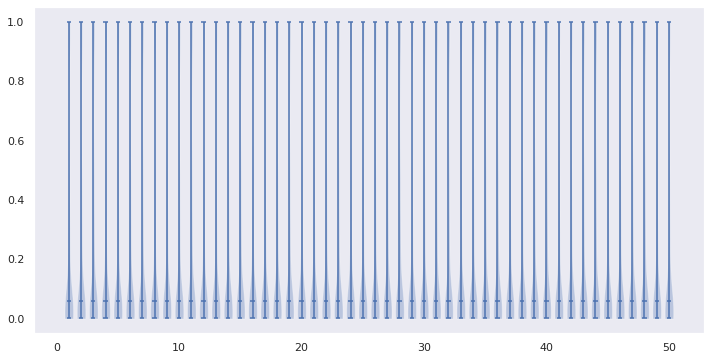

In [599]:

plt.figure(figsize=(12,6))
plt.violinplot(all_dist_L, widths=0.7, showmedians=True)
plt.show()

## Specific topic over time

### Function to get terms-timestamps heatmap

In [162]:
def terms_tss_heatmap(topic, redun_terms={}):
  # Get a dataframe for all data in topics_over_time for the topic of interest
  data = topics_over_time.loc[
    topics_over_time.Topic.isin([topic]), :].sort_values(["Topic", "Timestamp"])
    
  # Put top terms at different timestamps into a matrix
  toc_terms = data['Words']
  toc_tss   = data['Timestamp']

  # get all terms and put them in a dictionary
  toc_terms_all = {} # {term: count}
  for terms in toc_terms:
    terms_list = terms.split(", ")
    for term in terms_list:
      # Ignore number terms
      if (not term.isnumeric() and term != 'plant') or term == '1433':
        # replace the current term
        if term in redun_terms:
          term = redun_terms[term]

        if term not in toc_terms_all:
          toc_terms_all[term] = 1
        else:
          toc_terms_all[term]+= 1
  
  # Construct term-tss dictionary to count term frequency
  terms_tss = {}  # {ts:{term:1}}
  for idx, ts in enumerate(toc_tss):
    toc_terms_list = toc_terms.iloc[idx].split(", ")
    terms_tss[ts]  = {}
    for term in toc_terms_all:
      if term in toc_terms_list:
        terms_tss[ts][term] = 1
      else:
        terms_tss[ts][term] = 0

  # deal with situation when some timestamp does not exist
    # Check if all 50 timestamp bins are present, if not, fill in zero.
  for ts in ts_unique:
    if ts not in terms_tss:
      print("missing", ts, datetime.fromtimestamp(ts))
      terms_tss[ts] = {}
      for term in toc_terms_all:
        terms_tss[ts][term] = 0

  # Construct terms-timestamps dataframe: 
  terms_tss_df = pd.DataFrame.from_dict(terms_tss)

  # Sort df based on column names (timestamps)
  terms_tss_df.sort_index(axis=1, inplace=True)

  # Draw and save heatmap
  cgrid = sns.clustermap(terms_tss_df, row_cluster=True, col_cluster=False,
                         cmap="mako", method='weighted',)
  #cgrid.savefig(tot_graph_dir / f'tot_graph_topic_{topic}_terms.pdf')
  plt.close()
  
  # Get the row order and reorderd the dataframe
  order_idx = cgrid.dendrogram_row.reordered_ind
  terms_tss_df_index = terms_tss_df.index
  order_terms = [terms_tss_df_index[term_idx] for term_idx in order_idx]
  terms_tss_df_reordered = terms_tss_df.reindex(order_terms)

  # heatmap x axis: reuse boundsX

  # heatmap y axis
  terms_idx  = np.arange(len(toc_terms_all))
  midpointsY = (terms_idx[:-1] + terms_idx[1:]) / 2
  boundsY    = np.concatenate([[2*midpointsY[0]-midpointsY[1]], 
                            midpointsY, 
                            [2*midpointsY[-1]-midpointsY[-2]]])
  #print(boundsX.shape, boundsY.shape, terms_tss_df_reordered.shape)
  
  # xtickslabels: reuse
  # yticklabels:
  yticklabels = terms_tss_df_reordered.index

  # Draw heatmap with size resacaled
  fig, ax = plt.subplots()
  plot = ax.pcolormesh(boundsX, boundsY, terms_tss_df_reordered, cmap="mako")
  ax.set_xticks(boundsX)
  ax.set_xticklabels(xticklabels, rotation=90)
  ax.set_yticks(np.arange(len(terms_idx)))
  ax.set_yticklabels(yticklabels)
  ax.grid(False)
  fig.colorbar(plot)
  plt.tight_layout()
  plt.savefig(tot_graph_dir / \
                f'tot_graph_topic_{topic}_scaled_heatmap_no_globaltune.pdf')
  
  plt.close() # prevent image from showing

  # print out the keys for defining if some terms should be considered redun
  toc_terms_all_list = list(toc_terms_all.keys())
  toc_terms_all_list.sort()
  print(len(toc_terms_all_list), toc_terms_all_list)

  return terms_tss_df 


### Topic 43

In [163]:
redun_terms43  = {'plants':'plant',
                  'roots':'root',
                  'leaves': 'leaf',
                  'photoperioid gene':'photoperiod',}
terms_tss_df43 = terms_tss_heatmap(43, redun_terms43)

46 ['air layers', 'area', 'ave', 'canopy', 'conditions', 'crop', 'day', 'deficit', 'delta', 'dle', 'dormancy', 'drought', 'epsilon', 'fruit', 'fruit growth', 'fruitset', 'germination', 'graft', 'grain', 'growth', 'leaf', 'leaf area', 'light', 'light interception', 'lodging', 'model', 'phenotyping', 'photoperiod', 'photoperiod gene', 'potential', 'pressure', 'rate', 'root', 'seeds', 'shoot', 'soil', 'temperature', 'traits', 'turgor', 'vegetative', 'vessels', 'water', 'water potential', 'xylem', 'xylem pressure', 'yield']


### Topic 39

In [164]:
redun_terms39  = {'plants':'plant',
                  'roots':'root',
                  'transformed':'transformation',
                  'genetic transformation':'transformation',
                  'agrobacteriummediated':'agrobacterium'}
terms_tss_df39 = terms_tss_heatmap(39, redun_terms39)

38 ['agartrap', 'agrobacterium', 'agrobacterium tumefaciens', 'agrobacteriummediated transformation', 'biolistic', 'cotton', 'crcre', 'dna', 'efficient', 'expression', 'expression cassette', 'gene', 'gus', 'kanamycin', 'method', 'octopine', 'plant', 'plasmid', 'plastid', 'plastid transformation', 'protocol', 'selectable', 'selection', 'superagrobacterium', 'system', 'tdna', 'ti', 'transformation', 'transformation efficiency', 'transgene', 'transgenic', 'transgenic plants', 'transient', 'tumefaciens', 'tumor', 'tumors', 'vector', 'vectors']


### Topic 86

In [165]:
redun_terms86  = {'plants':'plant',
                  'populations':'population'}
terms_tss_df86 = terms_tss_heatmap(86, redun_terms86)

29 ['adaptation', 'characters', 'clonal', 'depression', 'dispersal', 'evolution', 'evolutionary', 'fitness', 'genetic', 'gynodioecy', 'inbreeding', 'inbreeding depression', 'males', 'maternal', 'mating', 'mating activity', 'outcrossing', 'pollen', 'population', 'reproductive', 'selection', 'selfing', 'sexual', 'sm lab', 'society study', 'species', 'traits', 'trioecy', 'variation']


### Topic 25

In [166]:
redun_terms25  = {'plants':'plant',
                  'signalling':'signaling',
                  'cells':'cell'}
terms_tss_df25 = terms_tss_heatmap(25, redun_terms25)

38 ['aba', 'abp', 'abscission', 'auxin', 'cell', 'cell division', 'cortical', 'cortical parenchyma', 'development', 'division', 'dome', 'ear', 'ear shoot', 'ethylene', 'growth', 'growth morphogenesis', 'hormone', 'hormones', 'kinases', 'lamina', 'leaf', 'meristem', 'organs', 'parenchyma', 'pathways', 'phosphorelay', 'primordium', 'protein kinases', 'review', 'root', 'shoot inversion', 'signal', 'signal transduction', 'signaling', 'tassel', 'tassel ear', 'tch', 'transduction']


### Topic 23

In [167]:
redun_terms23  = {'plants':'plant',
                  'genes':'gene',
                  'madsbox gene': 'madsbox'}
terms_tss_df23 = terms_tss_heatmap(23, redun_terms23)

missing 250750799.0 1977-12-11 23:59:59
missing 425879999.0 1983-06-30 23:59:59
missing 546839999.0 1987-04-30 23:59:59
42 ['12s', 'actin', 'adhs', 'ahas', 'ahas1', 'ahas3', 'analysis', 'arabidopsis', 'attps', 'beta', 'beta fruct3', 'cbps', 'cp shsps', 'cyclins', 'cyps', 'dhfr', 'ets', 'expression', 'family', 'four genes', 'fruct3', 'gene', 'gene family', 'heatshock', 'kinesins', 'madsbox', 'madsbox genes', 'members', 'myb', 'phylogenetic', 'proteins', 'psbp', 'rice', 'seed storage', 'shsps', 'small heatshock', 'storage protein', 'stress', 'subfamily', 'wrky', 'zrnasei', 'zrnaseii']


### Topic 61

In [168]:
redun_terms61  = {'plants':'plant',
                  'qtls':'qtl',
                  'chromosomes':'chromosome', 'hybrids': 'hybrid',}
terms_tss_df61 = terms_tss_heatmap(61, redun_terms61)

16 ['breeding', 'characters', 'chromosome', 'crosses', 'genetic', 'hybrid', 'lines', 'locus', 'mapping', 'markers', 'qtl', 'resistance', 'rflp', 'rust', 'traits', 'wheat']


### Topic 35

In [169]:
redun_terms35  = {'plants':'plant', 'trnas':'trna', 'trna leu':'trna',
                  'proteins':'protein', 'sequences':'sequence'}
terms_tss_df35 = terms_tss_heatmap(35, redun_terms35)

22 ['amino', 'arabidopsis', 'autophagy', 'cdna', 'chloroplast', 'domain', 'editing', 'er', 'expression', 'gene', 'import', 'membrane', 'opaque2', 'ppr', 'protein', 'rna', 'rna editing', 'sequence', 'splicing', 'trafficking', 'trna', 'wheat germ']


### Topic 42

In [170]:
redun_terms42  = {'plants':'plant', 'cdna':'cdna clones', 'clones':'cdna clones',
                  'proteins':'protein', 'ests':'est', 'em':'em expression',
                  'expression':'em expression','heat':'heat shock',
                  'shock':'heat shock',
                  'expressed':'expression'}
terms_tss_df42 = terms_tss_heatmap(42, redun_terms42)

39 ['2n42', 'aba', 'acids amides', 'amides', 'analysis', 'cdna clones', 'cma cmb', 'cme', 'degs', 'desiccation stress', 'differentially', 'drought', 'drought conditioning', 'elongatum', 'em expression', 'est', 'expression', 'genes', 'heat shock', 'highlysine mutations', 'hsps', 'isoline', 'metabolism', 'nacl', 'nonblue', 'pear mitochondria', 'primary root', 'protein', 'sdspage', 'sequences', 'soluble proteins', 'ss', 'stress', 'tennesseensis', 'transcriptome', 'trisomics', 'twodimensional', 'unigenes', 'zein']


### Topic 48

In [171]:
redun_terms48  = {'plants':'plant', 'glycans':'glycan',
                  'nglycan':'nglycosylation',
                  'purified':'purification',
                  'nglycans':'nglycosylation',
                  'lectins':'lectin'}
terms_tss_df48 = terms_tss_heatmap(48, redun_terms48)

39 ['activity', 'aochi', 'bagh5uv2', 'binding', 'bromelia', 'catalytic', 'chromatography', 'ctpme', 'db104', 'degrees', 'dehydrogenase', 'enzyme', 'eup82', 'ficin', 'galactosidase', 'gcp2', 'gel', 'glcnac', 'glycan', 'glycoproteins', 'glycosylation', 'kda', 'lectin', 'miraculin', 'nglycosylation', 'nitroxide', 'nom', 'pdiphenols', 'ph', 'prok', 'protein', 'ptsp2', 'purification', 'rbti', 'repricexip', 'sextet', 'sprdh', 'substrate', 'ttfaeb']


### Topic 27

In [172]:
redun_terms27  = {'plants':'plant','arrested':'arrested embryos',
                  'genes':'gene', 'mutants':'mutant', 
                  'species histone':'histone',}
terms_tss_df27 = terms_tss_heatmap(27, redun_terms27)

34 ['aborted seeds', 'arabidopsis', 'arrested embryos', 'auxin', 'cell', 'development', 'dn', 'embryolethal mutants', 'embryos', 'enriched media', 'expression', 'f2a1', 'floral', 'flowering', 'formation', 'ft', 'gene', 'histones', 'homeotic', 'kn1', 'lateral suppressor', 'lg1', 'meristem', 'meristems', 'migrate', 'migrate position', 'mutant', 'organ', 'ovule', 'pollen', 'sectors', 'shoot', 'species histones', 'utut']


# Code development

### Testing datetime

Python `datetime` module: [doc](https://docs.python.org/3/library/datetime.html)
- `date` obj: represents a date (year, month and day) in an idealized calendar. This is the date I have. But Bertopic is asking for a timestamp.
- `datetime.timestamp()` method: Return POSIX timestamp corresponding to the datetime instance.

In [ ]:
# Get current datetime obj
now = datetime.now()
type(now), now

In [ ]:
# Get pandas series dates
dates = df_corpus['Date']
dates[0], dates[1]

In [ ]:
# turn the 1st date into a datetime obj
date0 = dates[0].split('-')
dt0   = datetime(int(date0[0]), int(date0[1]), int(date0[2]))
dt0

In [ ]:
# turn datetime into timestamp
ts0 = dt0.timestamp()
ts0

### Run `topic_over_time`

This is not used because the output is not as useful as I like. Particularly, I want to get the modified c-Tf-Idf values of differnt time bins. So this is replaced with manual run.

In [ ]:
topics_over_time_ts3 = topic_model.topics_over_time(docs, topics, timestamps3, 
                                                    nr_bins=50,
                                                    evolution_tuning=True,
                                                    global_tuning=True)

In [ ]:
topic_ot_ts3_file = work_dir / "topics_over_time_ts3_no_global_tune.tsv"
topics_over_time_ts3.to_csv(topic_ot_ts3_file, sep="\t")

In [ ]:
topics_over_time_ts3

### Gettimg topic-over-time graph x-axis

In [141]:
unique_tss = topics_over_time.loc[topics_over_time.Topic == 3, :].Timestamp.to_list()
datetimes  = [datetime.fromtimestamp(ts) for ts in unique_tss]
ymds       = [f'{dt.year}-{dt.month}-{dt.day}' for dt in datetimes]
len(unique_tss), len(ymds)

(50, 50)

In [58]:
unique_tss[:5], unique_tss[-5:]

NameError: name 'unique_tss' is not defined

In [143]:
# At recent date it becomes too dense, so only show every 2 dates
skip_after = datetime(2011, 1, 1).timestamp()
skip_start_idx = bisect(unique_tss, skip_after)
unique_tss2 = unique_tss[:skip_start_idx] + unique_tss[skip_start_idx::2]
ymds2       = ymds[:skip_start_idx] + ymds[skip_start_idx::2]
len(unique_tss2), len(ymds2)

(37, 37)

In [148]:
unique_tss2[:5], unique_tss2[-5:]

([250750799.0, 425879999.0, 546839999.0, 638945999.0, 712641599.0],
 [1532750399.0, 1554177599.0, 1574053199.0, 1592711999.0, 1609477200.0])

### Min-max scaling

In [494]:
toc_data = topics_over_time.loc[topics_over_time.Topic == 8, :]
tss      = toc_data.Timestamp.values.tolist()
# frequency for each timestamp
freq = toc_data.Frequency.values.tolist()
# Deal with max values in the five topics specified
if topic in toc_outlier_modify:
  # index of max value
  idx_max    = freq.index(max(freq))
  # create a new list and remove the max value
  freq_copy = freq.copy()
  freq_copy.remove(max(freq))
  # index of the second max value
  idx_2ndmax = freq_copy.index(max(freq_copy))
  # set max value to 120% of the 2nd max value
  freq[idx_max] = freq[idx_2ndmax]*1.2

min(freq), max(freq), len(freq)

(1, 66, 37)

In [495]:
freq = np.reshape(freq, (1, len(freq)))
freq

array([[ 1,  1,  1,  3,  1,  1,  1,  1,  3,  4,  8, 13, 21, 28, 25, 30,
        26, 40, 42, 40, 57, 48, 49, 59, 52, 61, 51, 47, 44,  4, 66, 38,
        38, 39, 49, 39, 26]])

In [496]:
freq = minmax_scale(freq, axis=1)[0]
freq


array([0.        , 0.        , 0.        , 0.03076923, 0.        ,
       0.        , 0.        , 0.        , 0.03076923, 0.04615385,
       0.10769231, 0.18461538, 0.30769231, 0.41538462, 0.36923077,
       0.44615385, 0.38461538, 0.6       , 0.63076923, 0.6       ,
       0.86153846, 0.72307692, 0.73846154, 0.89230769, 0.78461538,
       0.92307692, 0.76923077, 0.70769231, 0.66153846, 0.04615385,
       1.        , 0.56923077, 0.56923077, 0.58461538, 0.73846154,
       0.58461538, 0.38461538])

### Heatmap testing

In [ ]:
## Testing
cgrid = sns.clustermap(tot_freq_df_nona, cmap="coolwarm", 
                         xticklabels=True, yticklabels=True,
                         row_cluster=True, col_cluster=False,
                         method="single")
plt.close() # Prevent the image from showing

### Topic over time heatmap: Some topics have weird values

There are NAs in tot_freq_df.
- E.g., topic 2 has 0 at the last time point, even though it was high the data point before.
- Found that this is because the frequency values are not always of length 50.
- this is fixed.

Some clusters have sharp peaks:
- E.g., topic 75
- Turn out this is due to outlier values.

In [ ]:
toc_data2 = topics_over_time.loc[topics_over_time.Topic==2, :]
toc_data2_freq = toc_data2.Frequency.values.tolist()
len(toc_data2_freq), toc_data2_freq[-5:]

(49, [40, 50, 48, 36, 33])

In [ ]:
tot_freq_df.iloc[2].values[-5:]

array([50., 48., 36., 33., nan])

### Heatmap with scaled cell size

- See [this post](https://stackoverflow.com/questions/64356782/seaborn-heatmap-with-variating-cell-sizes)

/tmp/ipykernel_6789/2841233385.py:11: MatplotlibDeprecationWarning:

Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.



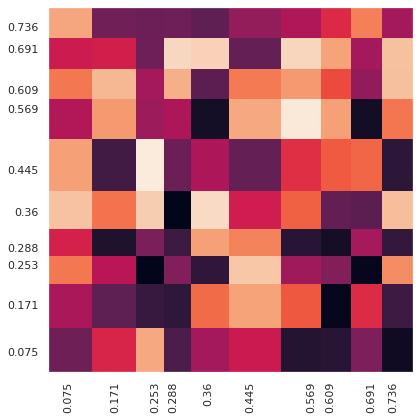

In [437]:
sns.set()
N = 10
xs = np.random.uniform(0.015, 0.13, 10).cumsum().round(3)  # some random x values
values = np.random.rand(N, N)  # a random matrix

# set bounds in the middle of successive cells, add extra bounds at start and end
bounds = (xs[:-1] + xs[1:]) / 2
bounds = np.concatenate([[2 * bounds[0] - bounds[1]], bounds, [2 * bounds[-1] - bounds[-2]]])

fig, ax = plt.subplots(figsize=(6,6))
ax.pcolormesh(bounds, bounds, values)

ax.set_xticks(xs)
ax.set_xticklabels(xs, rotation=90)
ax.set_yticks(xs)
ax.set_yticklabels(xs, rotation=0)
plt.tight_layout()
plt.show()

### Testing dict to dataframe

https://stackoverflow.com/questions/13575090/construct-pandas-dataframe-from-items-in-nested-dictionary

In [615]:
user_dict = {12: {'Category 1': {'att_1': 1, 'att_2': 'whatever'},
                  'Category 2': {'att_1': 23, 'att_2': 'another'}},
             15: {'Category 1': {'att_1': 10, 'att_2': 'foo'},
                  'Category 2': {'att_1': 30, 'att_2': 'bar'}}}

In [616]:
{(i,j): user_dict[i][j] 
                           for i in user_dict.keys() 
                           for j in user_dict[i].keys()}

{(12, 'Category 1'): {'att_1': 1, 'att_2': 'whatever'},
 (12, 'Category 2'): {'att_1': 23, 'att_2': 'another'},
 (15, 'Category 1'): {'att_1': 10, 'att_2': 'foo'},
 (15, 'Category 2'): {'att_1': 30, 'att_2': 'bar'}}

### Testing get terms-timestamps matrix

In [662]:
# Get a dataframe for all data in topics_over_time for the topic of interest
data = topics_over_time.loc[topics_over_time.Topic.isin([53]), :].sort_values(
                                                        ["Topic", "Timestamp"])

In [663]:
# Put top terms at different timestamps into a matrix
toc_terms = data['Words']
toc_tss   = data['Timestamp']

In [664]:
# get all terms and put them in a dictionary
toc_terms_all = {}
for terms in toc_terms:
  terms_list = terms.split(", ")
  for term in terms_list:
    if term not in toc_terms_all:
      toc_terms_all[term] = 1
    else:
      toc_terms_all[term]+= 1
toc_terms_all

{'compounds': 50,
 'essential': 1,
 'oil': 11,
 'found': 1,
 'oils': 2,
 'plant': 14,
 'spp': 1,
 'species': 34,
 'alkaloid': 1,
 'alkaloids': 12,
 'essential oil': 3,
 'alfalfa': 1,
 'extracts': 3,
 'constituents': 3,
 'parthenolide': 1,
 'radicle hypocotyl': 1,
 'chemical': 13,
 'coca': 1,
 'products': 1,
 'biological': 3,
 'bryonia': 1,
 'peanut oil': 1,
 'glycitein': 1,
 'medicinal': 22,
 'glucosinolates': 1,
 'flavonoids': 5,
 'gossypol': 2,
 'brassinin': 3,
 'review': 23,
 'zuiki': 1,
 'pharmacological': 9,
 'parthenium': 1,
 'antioxidant': 1,
 'artemisinin': 2,
 'activities': 1,
 'kiwifruit': 1,
 'properties': 4,
 'biological activities': 1,
 'phytochemical': 2,
 'genus': 2,
 'health': 2,
 'natural': 1,
 'uses': 1,
 'food': 3,
 'bioactive': 2}

In [665]:
# Construct term-tss dictionary to count term frequency
terms_tss = {}  # {ts:{term:1}}
for idx, ts in enumerate(toc_tss):
  toc_terms_list = toc_terms.iloc[idx].split(", ")
  terms_tss[ts]  = {}
  for term in toc_terms_all:
    if term in toc_terms_list:
      terms_tss[ts][term] = 1
    else:
      terms_tss[ts][term] = 0
terms_tss

{250750799.0: {'compounds': 1,
  'essential': 1,
  'oil': 1,
  'found': 1,
  'oils': 1,
  'plant': 0,
  'spp': 0,
  'species': 0,
  'alkaloid': 0,
  'alkaloids': 0,
  'essential oil': 0,
  'alfalfa': 0,
  'extracts': 0,
  'constituents': 0,
  'parthenolide': 0,
  'radicle hypocotyl': 0,
  'chemical': 0,
  'coca': 0,
  'products': 0,
  'biological': 0,
  'bryonia': 0,
  'peanut oil': 0,
  'glycitein': 0,
  'medicinal': 0,
  'glucosinolates': 0,
  'flavonoids': 0,
  'gossypol': 0,
  'brassinin': 0,
  'review': 0,
  'zuiki': 0,
  'pharmacological': 0,
  'parthenium': 0,
  'antioxidant': 0,
  'artemisinin': 0,
  'activities': 0,
  'kiwifruit': 0,
  'properties': 0,
  'biological activities': 0,
  'phytochemical': 0,
  'genus': 0,
  'health': 0,
  'natural': 0,
  'uses': 0,
  'food': 0,
  'bioactive': 0},
 425879999.0: {'compounds': 1,
  'essential': 0,
  'oil': 0,
  'found': 0,
  'oils': 0,
  'plant': 1,
  'spp': 1,
  'species': 1,
  'alkaloid': 1,
  'alkaloids': 0,
  'essential oil': 0,
 

In [666]:
# Construct terms-timestamps dataframe: 
# start with zero-filled: not used
#https://stackoverflow.com/questions/22963263/creating-a-zero-filled-pandas-data-frame
#terms_tss_df = pd.DataFrame(0, index=toc_terms_all.keys(), columns=toc_tss)

# dict to dataframe
#https://stackoverflow.com/questions/13575090/construct-pandas-dataframe-from-items-in-nested-dictionary
terms_tss_df = pd.DataFrame.from_dict(terms_tss)
terms_tss_df

,2.507508e+08,4.258800e+08,5.468400e+08,6.389460e+08,7.126416e+08,7.783920e+08,8.361936e+08,8.975376e+08,9.497268e+08,9.869616e+08,...,1.521864e+09,1.532750e+09,1.543986e+09,1.554178e+09,1.564027e+09,1.574053e+09,1.583557e+09,1.592712e+09,1.601438e+09,1.609477e+09
compounds,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
essential,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
oil,1,0,1,0,0,0,0,1,1,0,...,0,0,0,0,0,0,0,0,0,1
found,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
oils,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
plant,0,1,0,0,0,0,0,1,0,1,...,0,0,0,0,0,0,0,0,0,0
spp,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
species,0,1,1,1,1,0,0,1,0,1,...,1,1,1,0,0,1,0,1,0,0
alkaloid,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
alkaloids,0,0,1,1,1,1,1,0,0,1,...,0,0,0,0,0,0,1,0,0,0


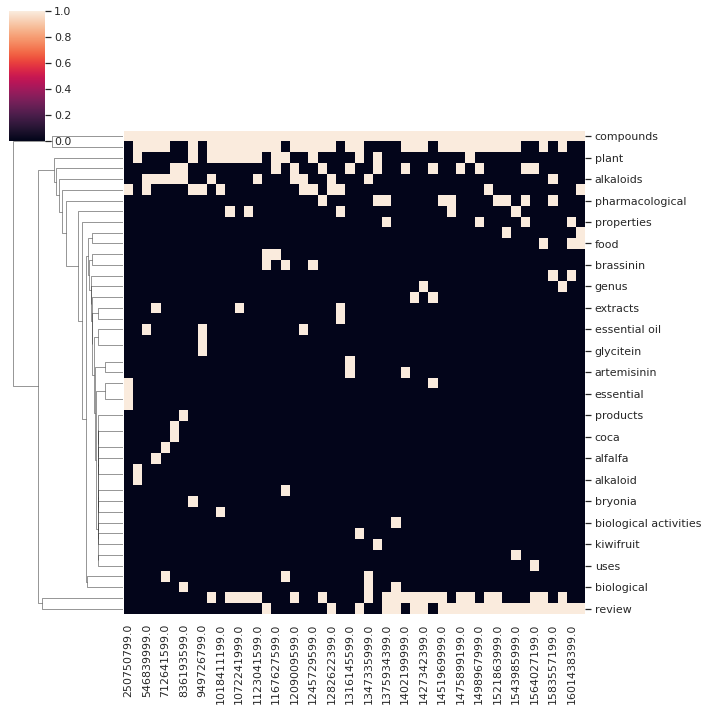

In [672]:
# Heatmap
cgrid_test = sns.clustermap(terms_tss_df, row_cluster=True, col_cluster=False)

In [668]:
terms_tss_df.index

Index(['compounds', 'essential', 'oil', 'found', 'oils', 'plant', 'spp',
       'species', 'alkaloid', 'alkaloids', 'essential oil', 'alfalfa',
       'extracts', 'constituents', 'parthenolide', 'radicle hypocotyl',
       'chemical', 'coca', 'products', 'biological', 'bryonia', 'peanut oil',
       'glycitein', 'medicinal', 'glucosinolates', 'flavonoids', 'gossypol',
       'brassinin', 'review', 'zuiki', 'pharmacological', 'parthenium',
       'antioxidant', 'artemisinin', 'activities', 'kiwifruit', 'properties',
       'biological activities', 'phytochemical', 'genus', 'health', 'natural',
       'uses', 'food', 'bioactive'],
      dtype='object')

In [673]:
# Get the row order and reorderd the dataframe
order_idx = cgrid_test.dendrogram_row.reordered_ind
print(len(order_idx), order_idx)

45 [0, 7, 5, 16, 9, 2, 30, 25, 36, 40, 43, 26, 27, 44, 39, 38, 12, 31, 10, 21, 22, 32, 33, 4, 1, 3, 18, 15, 17, 14, 11, 6, 8, 29, 20, 24, 37, 34, 35, 41, 42, 13, 19, 23, 28]


In [675]:
terms_tss_df_index = terms_tss_df.index
order_terms = [terms_tss_df_index[term_idx] for term_idx in order_idx]
print(order_terms)

['compounds', 'species', 'plant', 'chemical', 'alkaloids', 'oil', 'pharmacological', 'flavonoids', 'properties', 'health', 'food', 'gossypol', 'brassinin', 'bioactive', 'genus', 'phytochemical', 'extracts', 'parthenium', 'essential oil', 'peanut oil', 'glycitein', 'antioxidant', 'artemisinin', 'oils', 'essential', 'found', 'products', 'radicle hypocotyl', 'coca', 'parthenolide', 'alfalfa', 'spp', 'alkaloid', 'zuiki', 'bryonia', 'glucosinolates', 'biological activities', 'activities', 'kiwifruit', 'natural', 'uses', 'constituents', 'biological', 'medicinal', 'review']


In [677]:
terms_tss_df_reordered = terms_tss_df.reindex(order_terms)
print(terms_tss_df_reordered.index)

Index(['compounds', 'species', 'plant', 'chemical', 'alkaloids', 'oil',
       'pharmacological', 'flavonoids', 'properties', 'health', 'food',
       'gossypol', 'brassinin', 'bioactive', 'genus', 'phytochemical',
       'extracts', 'parthenium', 'essential oil', 'peanut oil', 'glycitein',
       'antioxidant', 'artemisinin', 'oils', 'essential', 'found', 'products',
       'radicle hypocotyl', 'coca', 'parthenolide', 'alfalfa', 'spp',
       'alkaloid', 'zuiki', 'bryonia', 'glucosinolates',
       'biological activities', 'activities', 'kiwifruit', 'natural', 'uses',
       'constituents', 'biological', 'medicinal', 'review'],
      dtype='object')


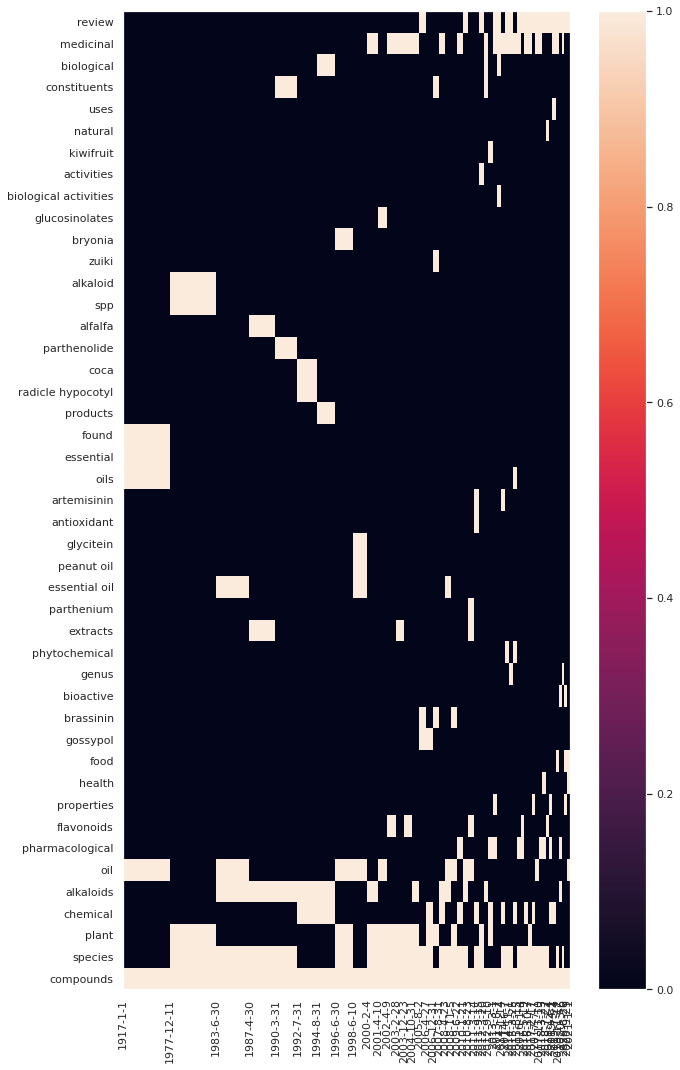

In [678]:
# heatmap x axis: reuse boundsX
# heatmap y axis
terms_idx  = np.arange(len(toc_terms_all))
midpointsY = (terms_idx[:-1] + terms_idx[1:]) / 2
boundsY    = np.concatenate([[2*midpointsY[0]-midpointsY[1]], 
                          midpointsY, 
                          [2*midpointsY[-1]-midpointsY[-2]]])
#print(boundsX.shape, boundsY.shape, terms_tss_df_reordered.shape)

# xtickslabels: reuse
# yticklabels:
yticklabels = terms_tss_df_reordered.index

# Draw heatmap with size resacaled
fig, ax = plt.subplots(figsize=(10,18))
plot = ax.pcolormesh(boundsX, boundsY, terms_tss_df_reordered)
ax.set_xticks(boundsX)
ax.set_xticklabels(xticklabels, rotation=90)
ax.set_yticks(np.arange(len(terms_idx)))
ax.set_yticklabels(yticklabels)
ax.grid(False)
fig.colorbar(plot)
plt.savefig(work_dir / 'fig4_4_tot_heatmap_weighted_xscaled.pdf')
plt.show()

### Test run the 1st time bin with manual topic_over_time

#### Get c-Tf-Idf matrix for the 1st time bin

In [ ]:
index = 0
timestamp = ts_unique[0]
timestamp

250750799.0

In [ ]:
# sub-dataframe: (8433, 4)
selection = documents.loc[documents.Timestamps == timestamp, :]

(pandas.core.frame.DataFrame, (78, 3))

In [ ]:
# joint docs for each topic into a string
docs_per_toc = selection.groupby(['Topic'], as_index=False).agg(
                                {'Document': ' '.join, "Timestamps": "count"})
docs_per_toc.shape

(78, 3)

In [ ]:
# Topic 61 is the 50th in the dataframe
docs_per_toc[docs_per_toc['Topic'] == 61]

,Topic,Document,Timestamps
50,61,[ distribution plastids mitosis guard cell mot...,288


In [ ]:
docs_per_toc.loc[50]

Topic                                                        61
Document      [ distribution plastids mitosis guard cell mot...
Timestamps                                                  288
Name: 50, dtype: object

In [ ]:
c_tf_idf, words = topic_model._c_tf_idf(docs_per_toc, fit=False)

In [ ]:
# c_tf_idf shape = (num_topics=78, num_words=18850331)
# Note that not all topics are found in the 1st time bin.
type(c_tf_idf), c_tf_idf.shape, type(words), len(words)

(scipy.sparse.csr.csr_matrix, (78, 18850331), list, 18850331)

In [ ]:
# Spot check a term
index_qtl = words.index('qtl')
c_tf_idf[50, index_qtl]

0.0

In [53]:
# Write the words into a file
word_file = ctfidf_dir / f"word_list_{len(words)}.pickle"
with open(word_file, 'wb') as f:
  pickle.dump(words, f)

In [55]:
# Write the index and topic name in docs_per_toc into a file
toc_index_file = ctfidf_dir / "ctfidf_0_toc_index.tsv"
docs_per_toc['Topic'].to_csv(toc_index_file, sep='\t')

#### Global tuning

- Evolution tuning is not done because this is the 1st time bin.
- Note that because of global tuning, the c-Tf-Idf value of qtl is no longer zero.

In [ ]:
selected_topics = [all_topics_indices[topic] \
                                        for topic in docs_per_toc.Topic.values]
c_tf_idf = (global_c_tf_idf[selected_topics] + c_tf_idf) / 2.0

In [ ]:
c_tf_idf[50, index_qtl]

0.0009095433190337633